# Real Estate Pricing Tier Classification 
Names: Thai, Laxmi, and Daniel

## Introduction
The real estate market is a dynamic and complex environment where property values fluctuate due to a myriad of factors. Our final project aims to demystify this volatility by developing a predictive model that can accurately classify properties into distinct price tiers. By analyzing a comprehensive dataset of real estate transactions, we intend to uncover patterns and indicators that influence pricing, thereby providing valuable insights for buyers, sellers, and investors alike. This endeavor not only seeks to enhance market transparency but also to empower stakeholders with a tool for informed decision-making in the real estate domain.

### Dataset

The dataset comprises over 4 million entries of U.S. real estate listings, segmented by state and zip code, sourced from Realtor.com, a leading property listing platform. It encompasses a comprehensive range of data points including housing status, number of bedrooms and bathrooms, land size in acres, city, state, postal code, living space in square feet, previous sale date, and the listing or recently sold price. This rich dataset provides a granular view of the current real estate market, offering valuable insights for various analyses and applications.

Dataset URL: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset/data


### Packages

In [54]:
# Install necessary packages (if not already installed)
!pip install pandas numpy matplotlib scikit-learn kaggle scipy

# Import required libraries
import kaggle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline

# Print a success message
print("All necessary packages are installed and imported successfully.")

All necessary packages are installed and imported successfully.


## Exploratory Data Analysis

### Data collection

#### Pre-requisites
To download the dataset, please follow the below steps:
1. Create a Kaggle account
2. After logging in, go to your user settings page on Kaggle.
3. Click the “Create New Token” button.
4. This action will download a file named kaggle.json to your computer.
5. Copy this file to the directory 'C:\Users\<your_username>\.kaggle'

In [2]:
# After ensuring you’ve met the prerequisites, execute the following command to download the dataset
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

with zipfile.ZipFile("usa-real-estate-dataset.zip","r") as zip_ref:
    
    # extracting content in the zipfile
    zip_ref.extractall()


usa-real-estate-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Load the dataset
df = pd.read_csv('realtor-data.zip.csv')

# Inspect the data
print(df.head())
print(df.info())

   brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   

         city        state  zip_code  house_size prev_sold_date  
0    Adjuntas  Puerto Rico     601.0       920.0            NaN  
1    Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2  Juana Diaz  Puerto Rico     795.0       748.0            NaN  
3       Ponce  Puerto Rico     731.0      1800.0            NaN  
4    Mayaguez  Puerto Rico     680.0         NaN            NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokere

### Data cleaning

In [4]:
# Print the list of columns in the original DataFrame before cleaning
print("Original columns:", df.columns)

# Remove columns that are irrelevant
df.drop(['brokered_by', 'status', 'prev_sold_date', 'street'], axis=1, inplace=True)

# Handle missing values for numerical columns by imputing with the median
numerical_columns = ['bed', 'bath', 'acre_lot', 'house_size', 'price']
df[numerical_columns] = df[numerical_columns].apply(lambda x: x.fillna(x.median()), axis=0)

# Assuming 'city' and 'state' are the only categorical columns with missing values
# Handle missing values for categorical columns by imputing with the mode (most common value)
categorical_columns = ['city', 'state', 'zip_code']
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]), axis=0)

# Display all unique values in the 'state' column
print("\nAll states (Unfiltered):")
print(df['state'].unique())

# Define the list of states to delete
delete_states = ['New Brunswick', 'Puerto Rico', 'Virgin Islands', 'Guam']

# Filter the DataFrame to keep only rows where the 'state' column does not belong to the states to delete
df_cleaned = df[~df['state'].isin(delete_states)]

# Display USA states only in the 'state' column
print("\nUSA states only:")
print(df_cleaned['state'].unique())

# Recheck info
print("\nCleaned DataFrame:")
print(df_cleaned.info())
print("Cleaned columns:", df_cleaned.columns)

# Save the cleaned dataset
df_cleaned.to_csv('clean-realtor-data.zip.csv', index=False)

Original columns: Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date'],
      dtype='object')

All states (Unfiltered):
['Puerto Rico' 'Virgin Islands' 'Massachusetts' 'Connecticut'
 'New Hampshire' 'Vermont' 'New Jersey' 'New York' 'South Carolina'
 'Tennessee' 'Rhode Island' 'Virginia' 'Wyoming' 'Maine' 'Georgia'
 'Pennsylvania' 'West Virginia' 'Delaware' 'Louisiana' 'Ohio' 'California'
 'Colorado' 'Maryland' 'Missouri' 'District of Columbia' 'Wisconsin'
 'North Carolina' 'Kentucky' 'Michigan' 'Mississippi' 'Florida' 'Alabama'
 'New Brunswick' 'Texas' 'Arkansas' 'Idaho' 'Indiana' 'Illinois'
 'New Mexico' 'Iowa' 'Minnesota' 'South Dakota' 'Nebraska' 'North Dakota'
 'Montana' 'Oklahoma' 'Kansas' 'Oregon' 'Utah' 'Nevada' 'Washington'
 'Arizona' 'Hawaii' 'Guam' 'Alaska']

USA states only:
['Massachusetts' 'Connecticut' 'New Hampshire' 'Vermont' 'New Jersey'
 'New York' 'South Carolina' 'Tennessee

#### Define Pricing Tier

In [5]:
# Define classification criteria for pricing tiers
def establish_pricing_tier(price):
    if price <= 300000:
        return 'Starter Homes (Tier 1)'
    elif price <= 500000:
        return 'Family-Friendly Homes (Tier 2)'
    elif price <= 1000000:
        return 'Executive Properties (Tier 3)'
    else:
        return 'Luxury Estates (Tier 4)'

# Apply classification criteria to create 'Pricing Tier' column
df['Pricing Tier'] = df['price'].apply(establish_pricing_tier)

# Define the order of pricing tiers
pricing_tier_order = [
    'Starter Homes (Tier 1)',
    'Family-Friendly Homes (Tier 2)',
    'Executive Properties (Tier 3)',
    'Luxury Estates (Tier 4)'
]

# Add 'Pricing Tier Order' column to DataFrame
df['Pricing Tier Order'] = pd.Categorical(df['Pricing Tier'], categories=pricing_tier_order, ordered=True)

# Reorder the DataFrame based on the pricing tier order
df = df.sort_values(by='Pricing Tier Order')

# Summary of classification criteria
print("\nClassification Criteria for Residential Properties:")
print("Starter Homes (Tier 1): Affordable options below $300,000, ideal for first-time homebuyers or those on a budget.")
print("Family-Friendly Homes (Tier 2): Mid-range properties between $300,001 and $500,000, suitable for families.")
print("Executive Properties (Tier 3): Upscale living between $500,001 and $1,000,000, featuring modern amenities.")
print("Luxury Estates (Tier 4): High-end properties above $1,000,000, offering expansive living spaces and premium finishes.")


Classification Criteria for Residential Properties:
Starter Homes (Tier 1): Affordable options below $300,000, ideal for first-time homebuyers or those on a budget.
Family-Friendly Homes (Tier 2): Mid-range properties between $300,001 and $500,000, suitable for families.
Executive Properties (Tier 3): Upscale living between $500,001 and $1,000,000, featuring modern amenities.
Luxury Estates (Tier 4): High-end properties above $1,000,000, offering expansive living spaces and premium finishes.


#### Remove Duplicate Rows

In [6]:
# Remove duplicate rows
print('Number of duplicate rows: ', df.duplicated().sum())
df_cleaned = df.copy()  # Corrected variable name
df_cleaned.drop_duplicates(inplace=True)
print('Number of duplicate rows after removal: ', df_cleaned.duplicated().sum())

Number of duplicate rows:  199653
Number of duplicate rows after removal:  0


#### Check for Missing Values

In [7]:
# Check for missing values (null)
print(df_cleaned.isnull().sum()) 

price                 0
bed                   0
bath                  0
acre_lot              0
city                  0
state                 0
zip_code              0
house_size            0
Pricing Tier          0
Pricing Tier Order    0
dtype: int64


In [8]:
# Check for missing values (na)
df_cleaned.isna().sum()

price                 0
bed                   0
bath                  0
acre_lot              0
city                  0
state                 0
zip_code              0
house_size            0
Pricing Tier          0
Pricing Tier Order    0
dtype: int64

### Descriptive Statistics

In [9]:
# Summary statistics for numerical columns
df_cleaned.describe()

,price,bed,bath,acre_lot,zip_code,house_size
count,2.026729e+06,2.026729e+06,2.026729e+06,2.026729e+06,2.026729e+06,2.026729e+06
mean,5.371203e+05,3.229018e+00,2.391330e+00,1.354154e+01,5.191160e+04,2.530670e+03
std,2.229125e+06,1.427724e+00,1.508278e+00,7.220583e+02,2.912285e+04,7.309371e+05
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,1.725000e+05,3.000000e+00,2.000000e+00,1.700000e-01,2.932500e+04,1.450000e+03
50%,3.299000e+05,3.000000e+00,2.000000e+00,2.600000e-01,4.813400e+04,1.760000e+03
75%,5.590000e+05,4.000000e+00,3.000000e+00,7.000000e-01,7.806400e+04,2.165000e+03
max,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,9.999900e+04,1.040400e+09


In [10]:
# Summary statistics for categorical columns
df_cleaned.describe(include = ['object', 'category'])

,city,state,Pricing Tier,Pricing Tier Order
count,2026729,2026729,2026729,2026729
unique,20098,55,4,4
top,Houston,Florida,Starter Homes (Tier 1),Starter Homes (Tier 1)
freq,22458,215222,937691,937691


In [11]:
# Counts of unique values in descending order
df_cleaned.value_counts()

price         bed  bath  acre_lot  city           state       zip_code  house_size  Pricing Tier                    Pricing Tier Order            
0.000000e+00  2.0  2.0   0.26      Brentwood      California  94513.0   1520.0      Starter Homes (Tier 1)          Starter Homes (Tier 1)            1
4.590000e+05  4.0  3.0   0.25      Sacramento     California  95828.0   1828.0      Family-Friendly Homes (Tier 2)  Family-Friendly Homes (Tier 2)    1
                                   Carrollton     Texas       75007.0   2535.0      Family-Friendly Homes (Tier 2)  Family-Friendly Homes (Tier 2)    1
                                   Bella Vista    Arkansas    72714.0   3196.0      Family-Friendly Homes (Tier 2)  Family-Friendly Homes (Tier 2)    1
                         0.24      Westmont       Illinois    60559.0   2055.0      Family-Friendly Homes (Tier 2)  Family-Friendly Homes (Tier 2)    1
                                                                                             

In [12]:
# Counts of unique values in descending order for original dataset
df.value_counts()

price         bed  bath  acre_lot  city            state         zip_code  house_size  Pricing Tier             Pricing Tier Order     
1.500000e+04  3.0  2.0   0.23      Lake Placid     Florida       33852.0   1760.0      Starter Homes (Tier 1)   Starter Homes (Tier 1)     87
2.990000e+04  3.0  2.0   0.23      Port Charlotte  Florida       33981.0   1760.0      Starter Homes (Tier 1)   Starter Homes (Tier 1)     86
1.500000e+04  3.0  2.0   0.25      Lehigh Acres    Florida       33971.0   1760.0      Starter Homes (Tier 1)   Starter Homes (Tier 1)     84
2.550000e+04  3.0  2.0   0.23      Citrus Springs  Florida       34434.0   1760.0      Starter Homes (Tier 1)   Starter Homes (Tier 1)     79
1.524690e+05  3.0  2.0   0.34      Vienna          Georgia       31092.0   1760.0      Starter Homes (Tier 1)   Starter Homes (Tier 1)     79
                                                                                                                                           ..
2.359000e+05

### Data Visualization

#### Outlier Detection

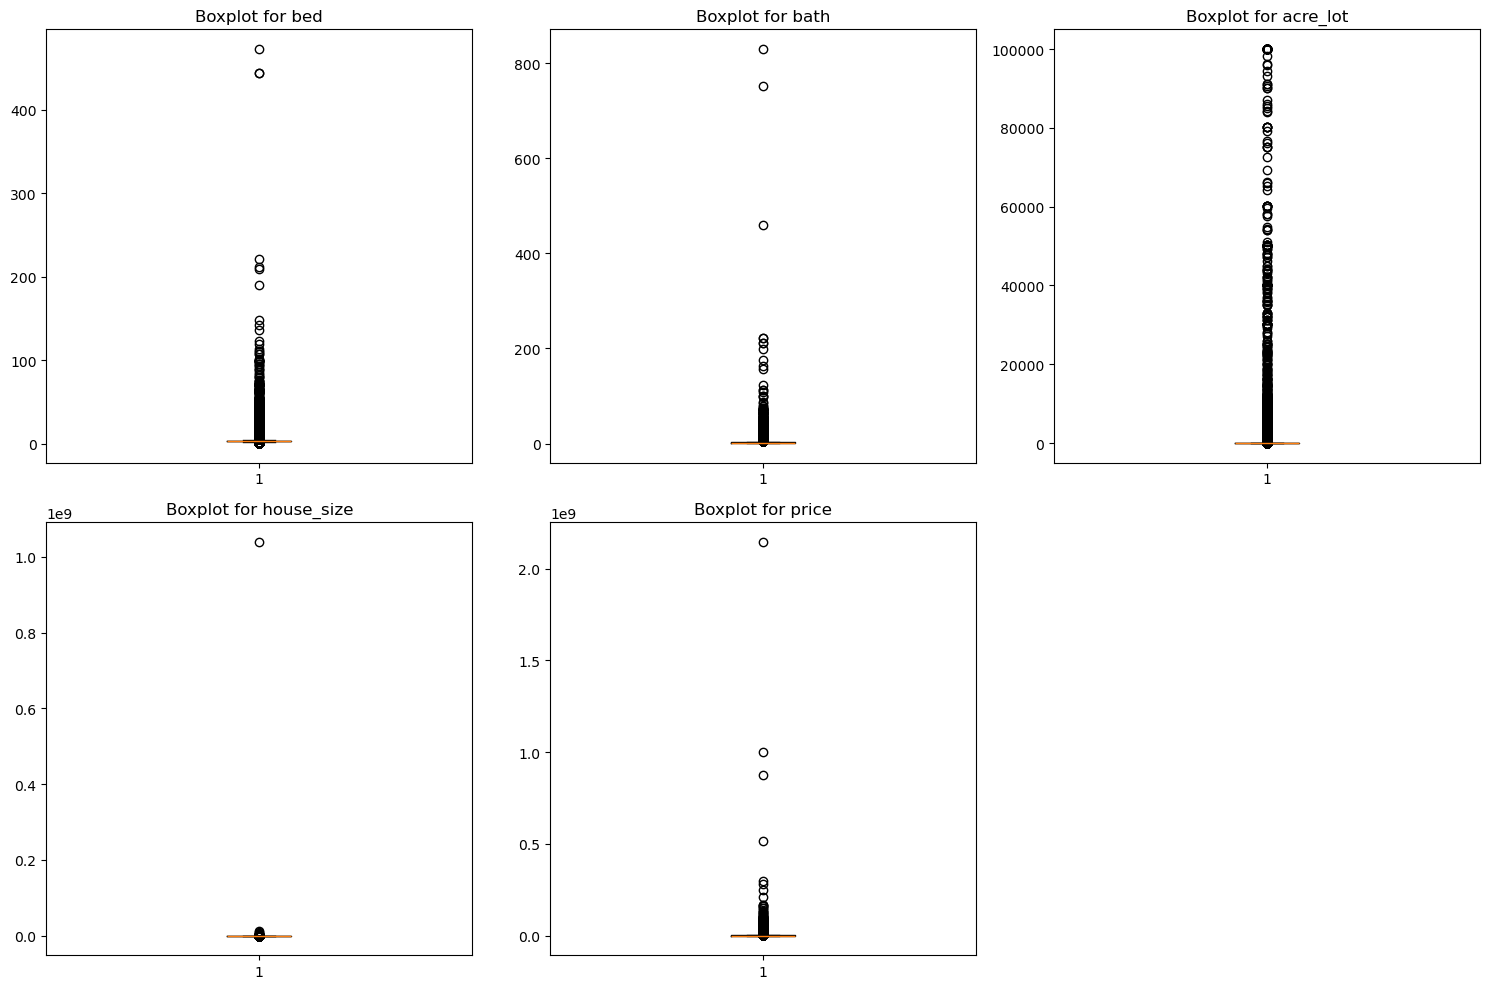

In [13]:
# Check for outliers with boxplot for numerical columns

# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot data on the first 5 subplots
axs[0, 0].boxplot(df_cleaned[numerical_columns[0]])
axs[0, 0].set_title(f'Boxplot for {numerical_columns[0]}')

axs[0, 1].boxplot(df_cleaned[numerical_columns[1]])
axs[0, 1].set_title(f'Boxplot for {numerical_columns[1]}')

axs[0, 2].boxplot(df_cleaned[numerical_columns[2]])
axs[0, 2].set_title(f'Boxplot for {numerical_columns[2]}')

axs[1, 0].boxplot(df_cleaned[numerical_columns[3]])
axs[1, 0].set_title(f'Boxplot for {numerical_columns[3]}')

axs[1, 1].boxplot(df_cleaned[numerical_columns[4]])
axs[1, 1].set_title(f'Boxplot for {numerical_columns[4]}')

# Remove the last (empty) subplot
fig.delaxes(axs[1][2])

# Display the figure with subplots
plt.tight_layout()
plt.show()

In [14]:
# Remove outliers for numerical columns

# Print total number of rows in filtered dataframe
print(f'Total rows with outliers : {df_cleaned.shape[0]}')

# Copy dataframe
df_no_outliers = df_cleaned.copy()

# Loop through numerical columns
for col in numerical_columns:
    # Calculate IQR
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

    # Print total number of rows after removal of outliers
    print(f'Total rows with out outliers for column {col} : {df_no_outliers.shape[0]}')

Total rows with outliers : 2026729
Total rows with out outliers for column bed : 1916464
Total rows with out outliers for column bath : 1865263
Total rows with out outliers for column acre_lot : 1553027
Total rows with out outliers for column house_size : 1470461
Total rows with out outliers for column price : 1386705


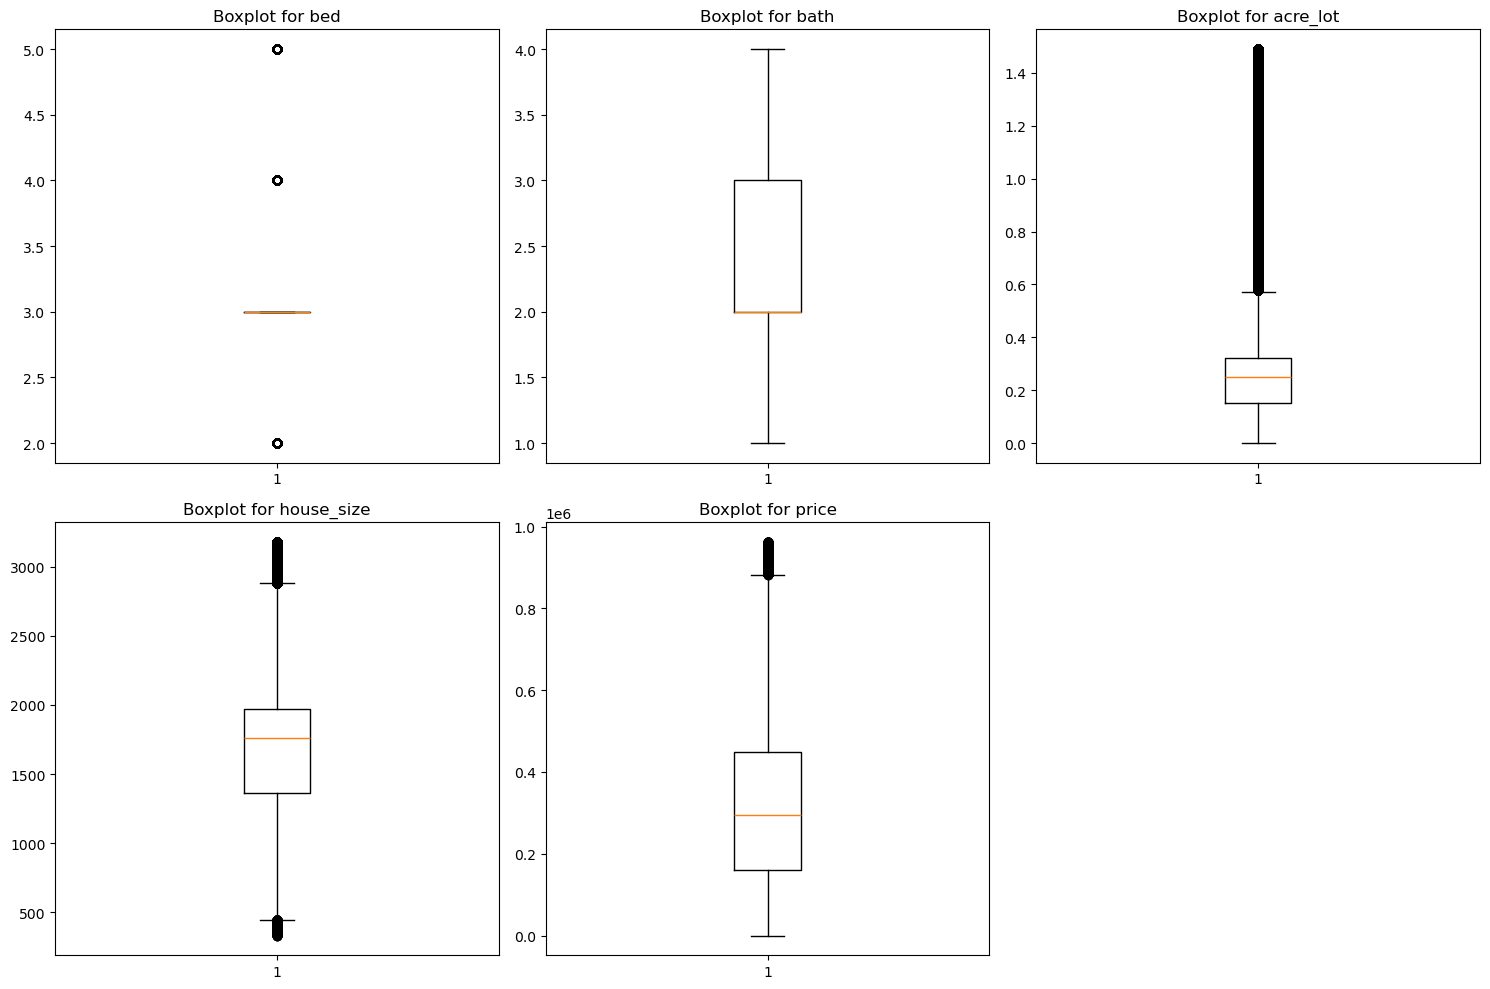

In [15]:
# Plot boxplots after removal of outliers from numerical columns

# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot data on the first 5 subplots
axs[0, 0].boxplot(df_no_outliers[numerical_columns[0]])
axs[0, 0].set_title(f'Boxplot for {numerical_columns[0]}')

axs[0, 1].boxplot(df_no_outliers[numerical_columns[1]])
axs[0, 1].set_title(f'Boxplot for {numerical_columns[1]}')

axs[0, 2].boxplot(df_no_outliers[numerical_columns[2]])
axs[0, 2].set_title(f'Boxplot for {numerical_columns[2]}')

axs[1, 0].boxplot(df_no_outliers[numerical_columns[3]])
axs[1, 0].set_title(f'Boxplot for {numerical_columns[3]}')

axs[1, 1].boxplot(df_no_outliers[numerical_columns[4]])
axs[1, 1].set_title(f'Boxplot for {numerical_columns[4]}')

# Remove the last (empty) subplot
fig.delaxes(axs[1][2])

# Display the figure with subplots
plt.tight_layout()
plt.show()

#### Visualization

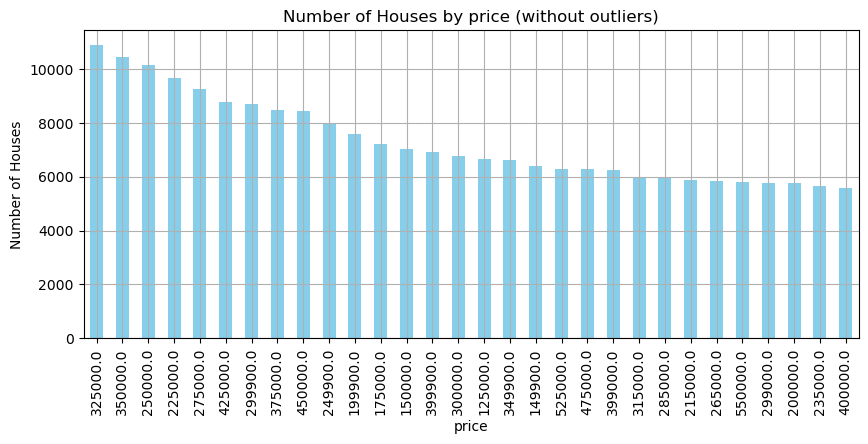

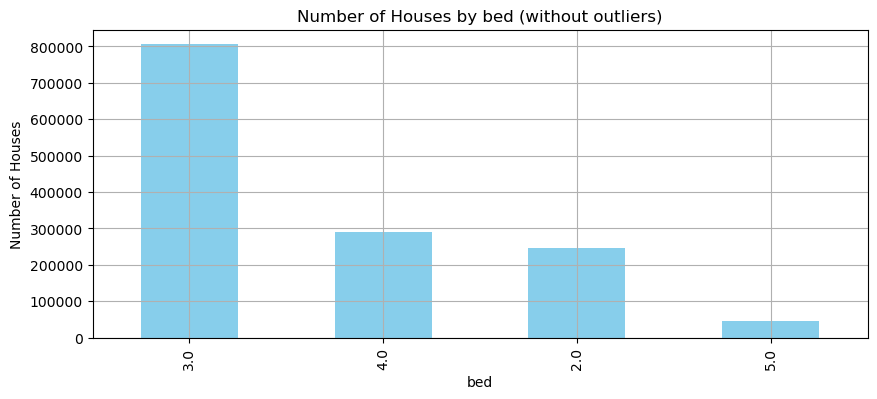

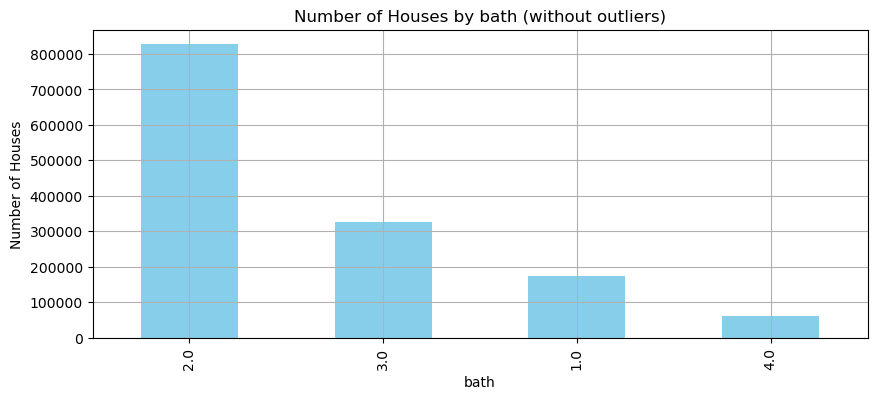

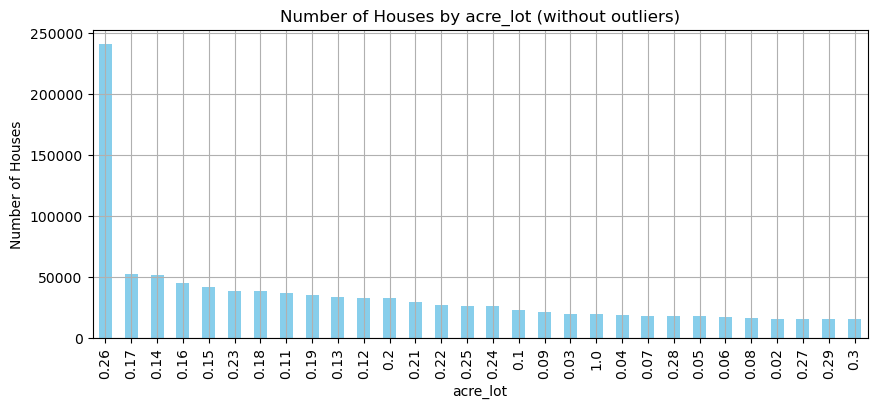

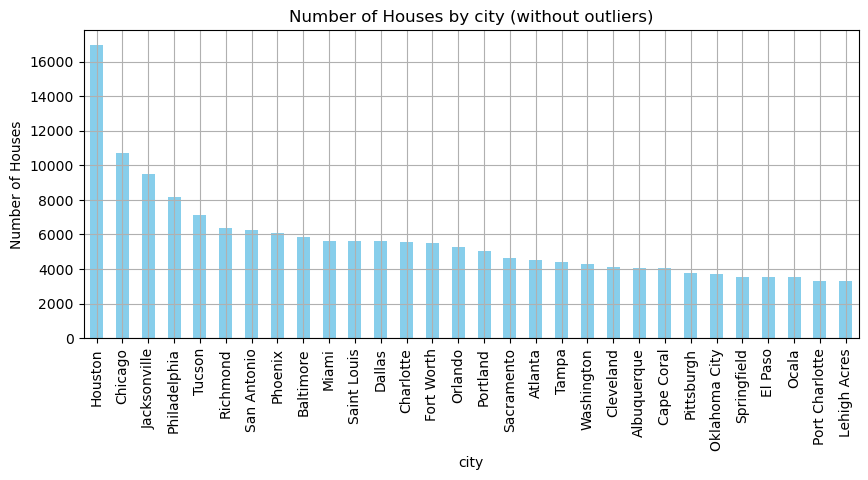

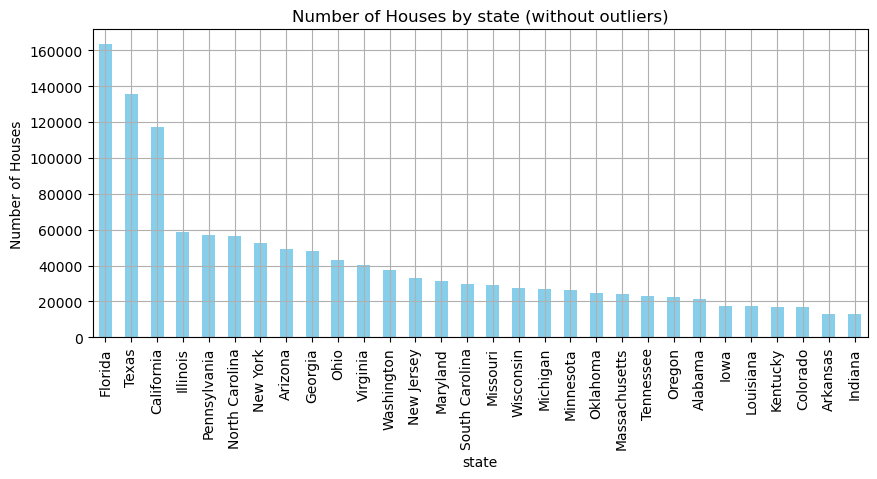

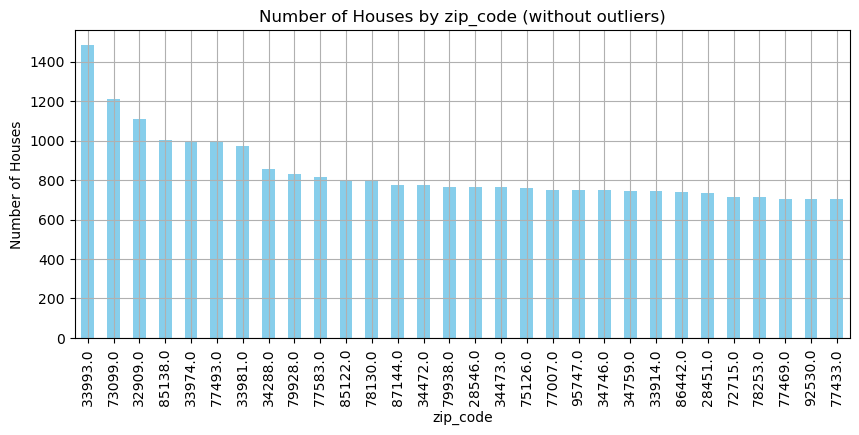

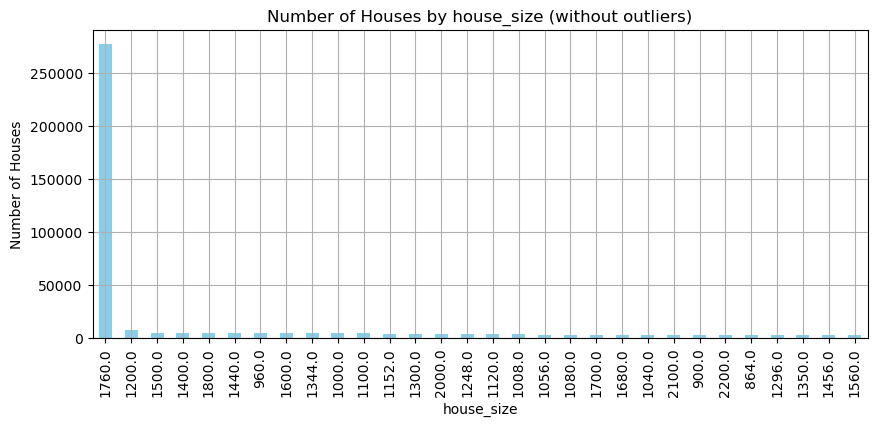

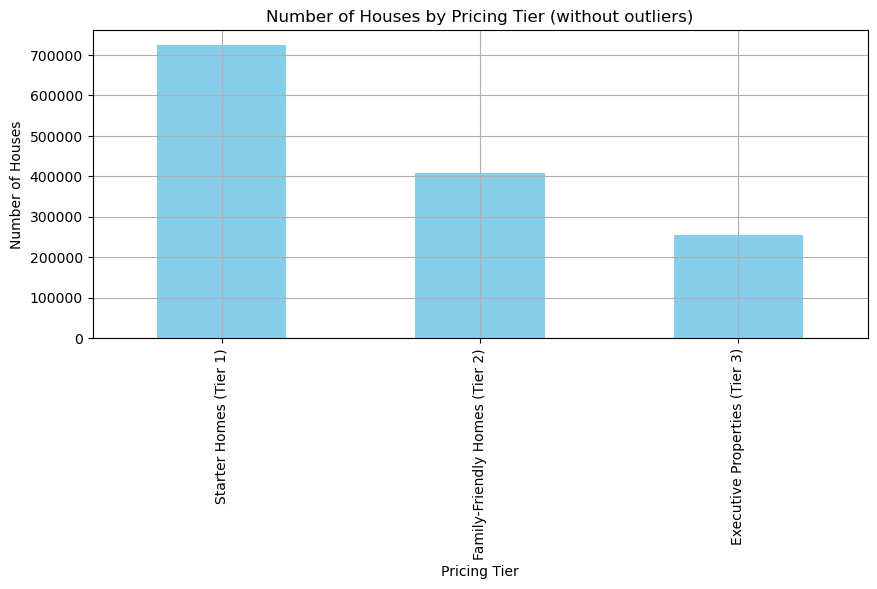

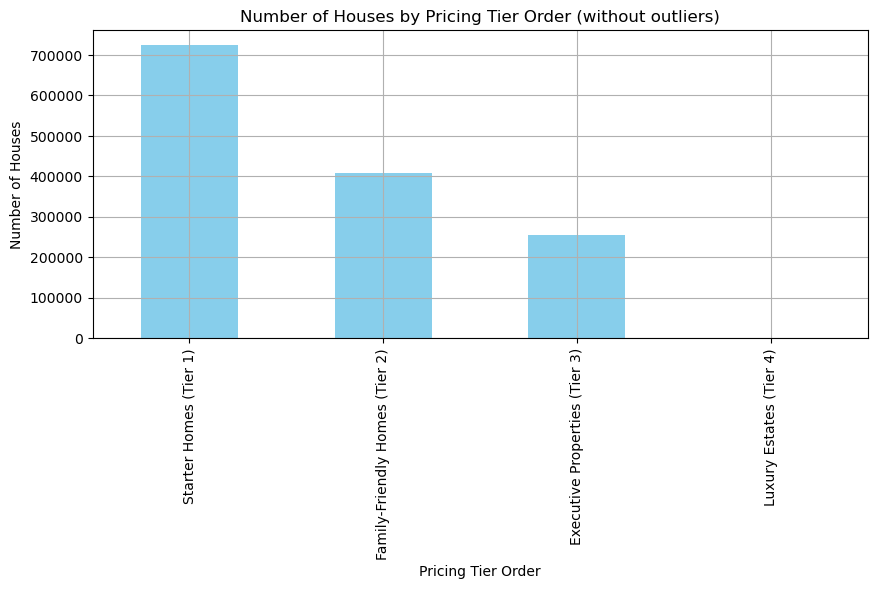

In [16]:
# Plot bar graph for each column (for data frame without outliers)
for col in df.columns:
    # Pick top 30 unique counts for bar chart
    df_no_outliers[col].value_counts().head(30).plot(kind='bar', figsize=(10,4), color='skyblue')

    # Set title, labels and display
    plt.title(f'Number of Houses by {col} (without outliers)')
    plt.xlabel(col)
    plt.ylabel('Number of Houses')
    plt.grid(True)
    plt.show()

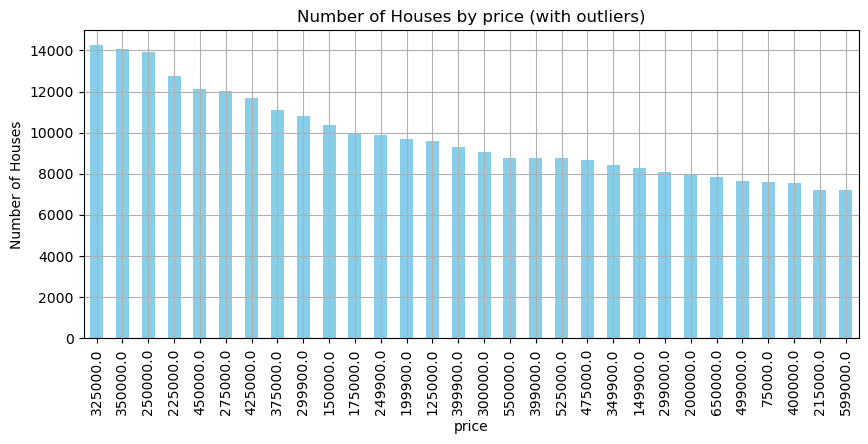

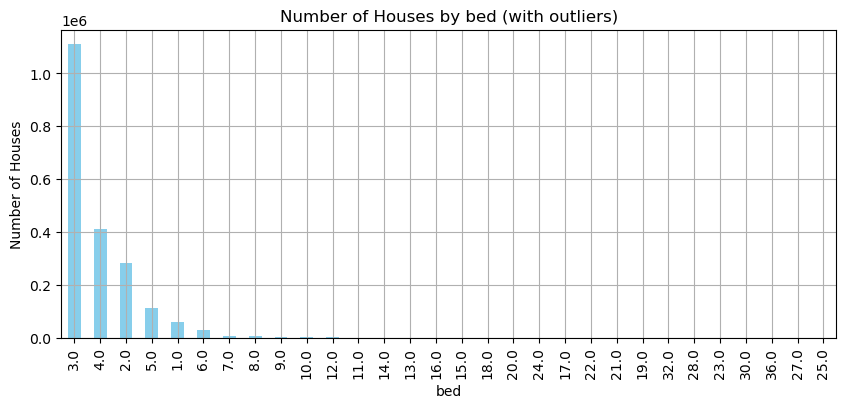

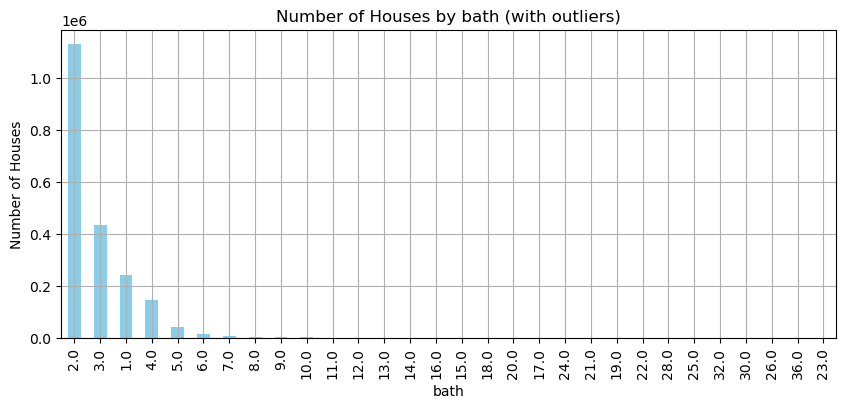

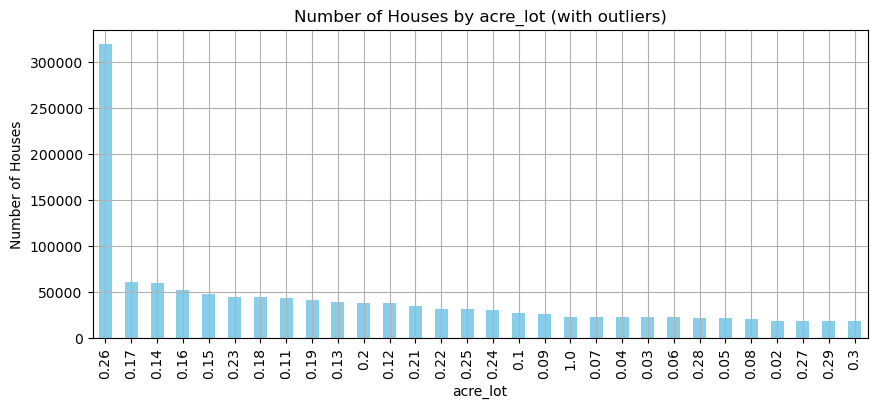

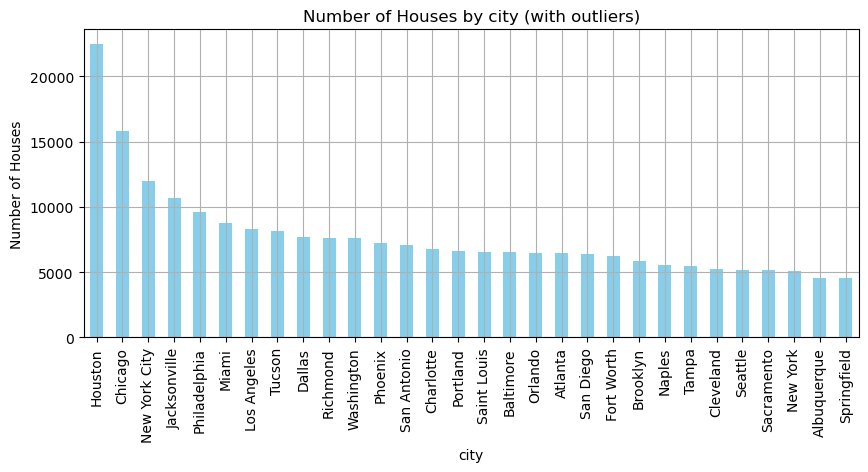

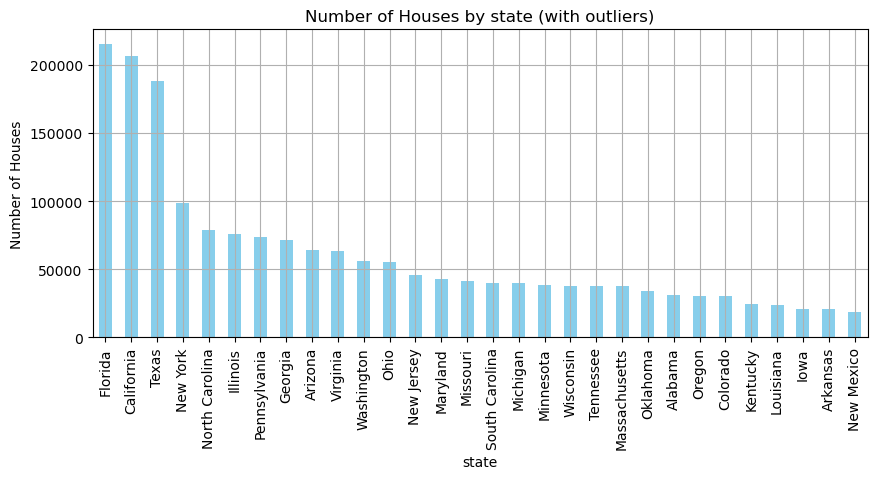

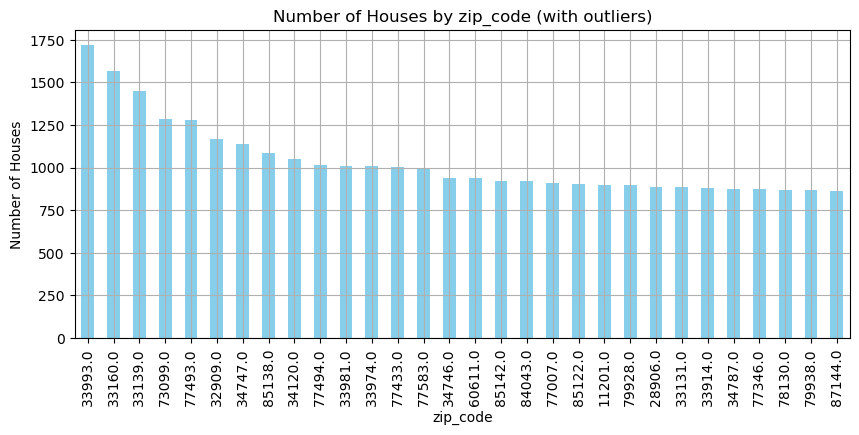

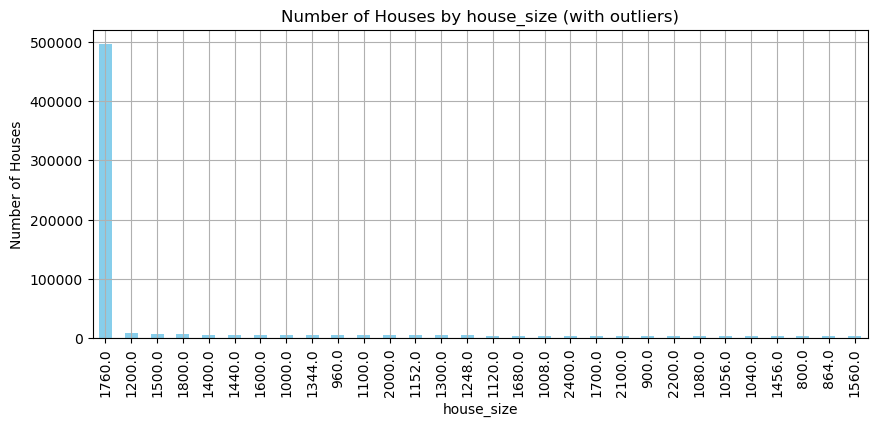

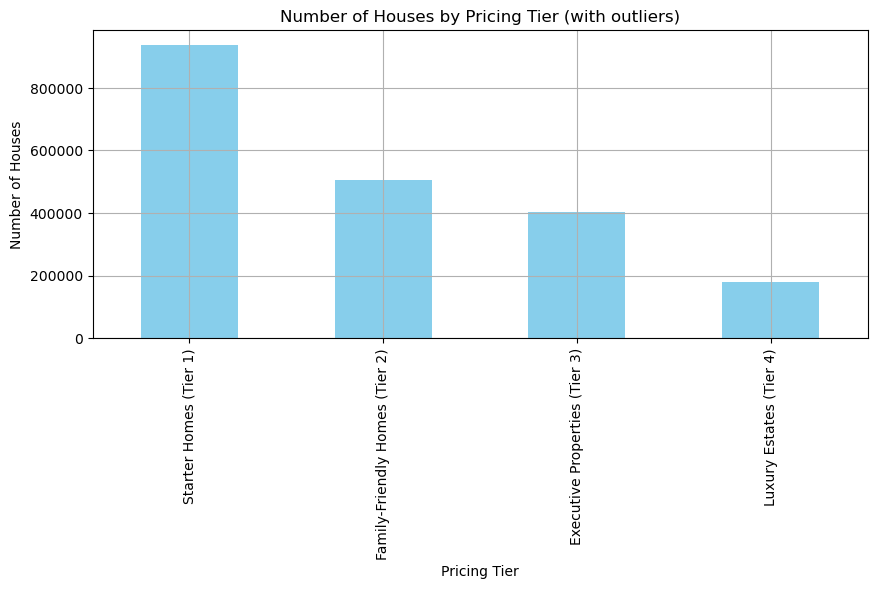

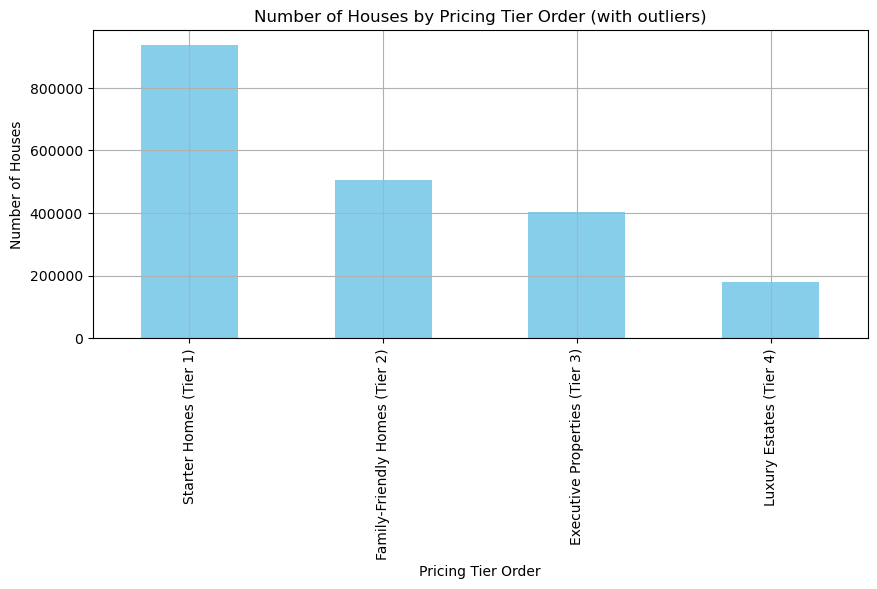

In [17]:
# Plot bar graph for each column (for data frame with outliers)
for col in df.columns:
    # Pick top 30 unique counts for bar chart
    df_cleaned[col].value_counts().head(30).plot(kind='bar', figsize=(10,4), color='skyblue')

    # Set title, labels and display
    plt.title(f'Number of Houses by {col} (with outliers)')
    plt.xlabel(col)
    plt.ylabel('Number of Houses')
    plt.grid(True)
    plt.show()

In [18]:
# Group by state, city, bed and bath
# Display mean values for acre_lot, house_size and price
print('Group by state, city, bed and bath for dataframe without outliers')
df_no_outliers.groupby(['state', 'city', 'bed', 'bath']).agg({'acre_lot' : 'mean', 'house_size' : 'mean', 'price' : 'mean'})

Group by state, city, bed and bath for dataframe without outliers


acre_lot   house_size          price
state   city      bed bath                                      
Alabama Abbeville 2.0 1.0   0.593333   887.666667  179333.333333
                      2.0   0.697500  1111.000000  111700.000000
                  3.0 1.0   0.255000   970.000000   33494.000000
                      2.0   0.569792  1738.416667  101290.625000
                  4.0 2.0   0.476667  1818.000000  364833.333333
...                              ...          ...            ...
Wyoming Wright    4.0 3.0   0.240000  2105.500000  227450.000000
                  5.0 3.0   0.100000  1986.000000  129900.000000
                      4.0   0.310000  2128.000000  274900.000000
        Yoder     2.0 1.0   0.260000  1456.000000   95000.000000
                  3.0 2.0   0.480000  2080.000000   99000.000000

[120844 rows x 3 columns]

In [19]:
# Group by state, city, bed and bath
# Display mean values for acre_lot, house_size and price
print('Group by state, city, bed and bath for dataframe with outliers')
df_cleaned.groupby(['state', 'city', 'bed', 'bath']).agg({'acre_lot' : 'mean', 'house_size' : 'mean', 'price' : 'mean'})

Group by state, city, bed and bath for dataframe with outliers


acre_lot   house_size          price
state   city      bed bath                                       
Alabama Abbeville 1.0 1.0    0.500000   700.000000   14500.000000
                      2.0    1.000000   659.000000  295000.000000
                  2.0 1.0    0.593333   887.666667  179333.333333
                      2.0    0.697500  1111.000000  111700.000000
                  3.0 1.0    1.540000  1136.666667  152296.000000
...                               ...          ...            ...
Wyoming Wyoming   3.0 2.0   39.700000  1760.000000   99900.000000
        Yoder     2.0 1.0    0.260000  1456.000000   95000.000000
                  3.0 2.0    0.480000  2080.000000   99000.000000
                  4.0 2.0   10.000000  2356.000000  325000.000000
                      3.0   35.000000  2494.000000  598000.000000

[210437 rows x 3 columns]

In [20]:
# Counts of unique values in descending order for price_tier (for dataframe without outliers)
df_no_outliers['Pricing Tier'].value_counts()

Pricing Tier
Starter Homes (Tier 1)            725202
Family-Friendly Homes (Tier 2)    407504
Executive Properties (Tier 3)     253999
Name: count, dtype: int64

In [21]:
# Counts of unique values in descending order for price_tier (for dataframe with outliers)
df_cleaned['Pricing Tier'].value_counts()

Pricing Tier
Starter Homes (Tier 1)            937691
Family-Friendly Homes (Tier 2)    505431
Executive Properties (Tier 3)     403912
Luxury Estates (Tier 4)           179695
Name: count, dtype: int64

Pricing Tier  Executive Properties (Tier 3)  Family-Friendly Homes (Tier 2)  \
bed bath                                                                      
2.0 1.0                              6995.0                         13021.0   
    2.0                             23576.0                         38832.0   
    3.0                              6900.0                          8049.0   
    4.0                               431.0                           513.0   
3.0 1.0                              5640.0                         11839.0   
    2.0                             58512.0                        126054.0   
    3.0                             41663.0                         59831.0   
    4.0                              8467.0                          8190.0   
4.0 1.0                               435.0                          1185.0   
    2.0                             21382.0                         43703.0   
    3.0                             47776.0         

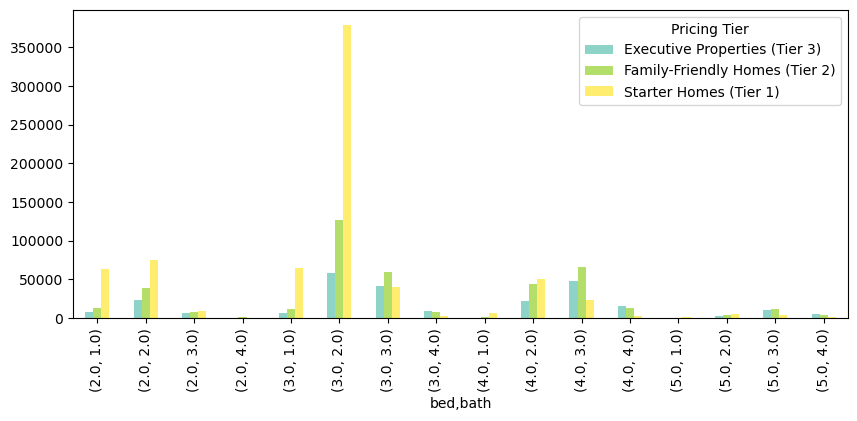

In [22]:
# Plot distribution of price tier by number of beds and baths (for dataframe without outliers)

# Group data by bed, bath and price tier
grouped = df_no_outliers.groupby(['bed', 'bath', 'Pricing Tier'], observed=False).size().reset_index(name='count')

# Create and print pivot table
pivot_table = pd.pivot_table(grouped, values='count', index=['bed', 'bath'], columns=['Pricing Tier'])
print(pivot_table)

# Plot bar chart for pivot table
pivot_table.plot(kind='bar', figsize=(10,4), colormap='Set3')
plt.show()

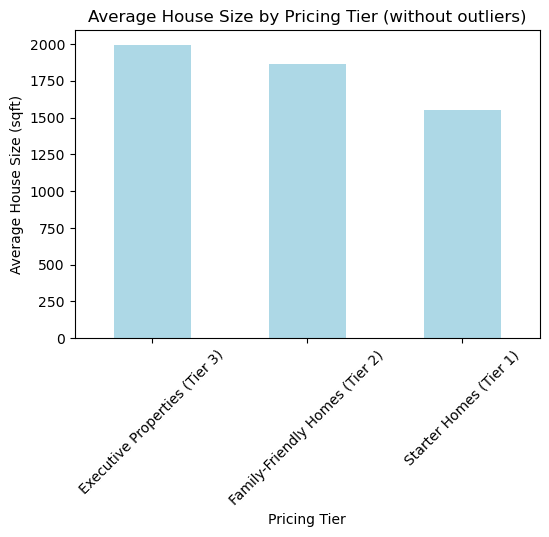

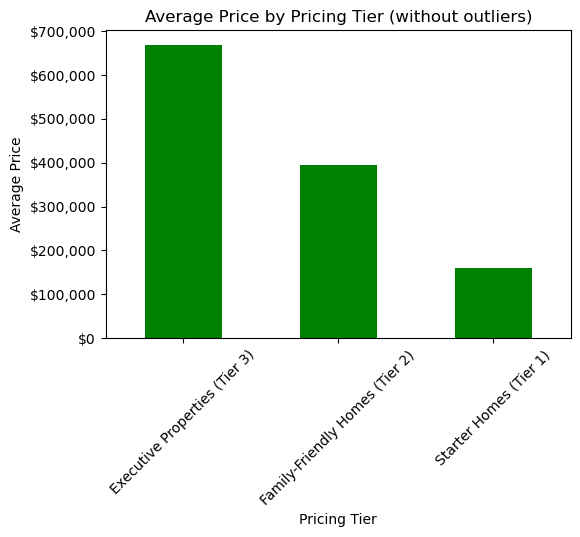

In [23]:
# Plot distribution of properties by property tier (for dataframe without outliers)
plt.figure(figsize=(6, 4))
df_no_outliers.groupby('Pricing Tier', observed=True)['house_size'].mean().sort_index().plot(kind='bar', color='lightblue')
plt.title('Average House Size by Pricing Tier (without outliers)')
plt.xlabel('Pricing Tier')
plt.ylabel('Average House Size (sqft)')
plt.xticks(rotation=45)
plt.show()

# Plot average price by property tier (for dataframe without outliers)
plt.figure(figsize=(6, 4))
ax = df_no_outliers.groupby('Pricing Tier', observed=True)['price'].mean().sort_index().plot(kind='bar', color='green')
plt.title('Average Price by Pricing Tier (without outliers)')
plt.xlabel('Pricing Tier')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Format y-axis labels as dollar amounts
formatter = '${x:,.0f}'
ax.yaxis.set_major_formatter(formatter)
plt.show()

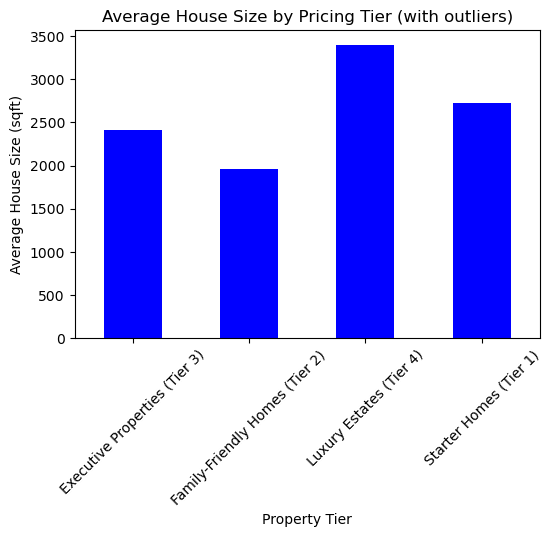

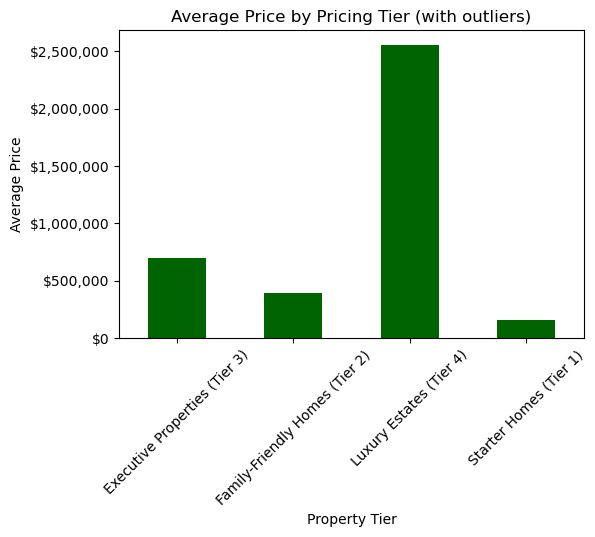

In [24]:
# Plot distribution of properties by property tier (for dataframe with outliers)
plt.figure(figsize=(6, 4))
df_cleaned.groupby('Pricing Tier', observed=True)['house_size'].mean().sort_index().plot(kind='bar', color='blue')
plt.title('Average House Size by Pricing Tier (with outliers)')
plt.xlabel('Property Tier')
plt.ylabel('Average House Size (sqft)')
plt.xticks(rotation=45)
plt.show()

# Plot average price by property tier (for dataframe with outliers)
plt.figure(figsize=(6, 4))
ax = df_cleaned.groupby('Pricing Tier', observed=True)['price'].mean().sort_index().plot(kind='bar', color='darkgreen')
plt.title('Average Price by Pricing Tier (with outliers)')
plt.xlabel('Property Tier')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Format y-axis labels as dollar amounts
formatter = '${x:,.0f}'
ax.yaxis.set_major_formatter(formatter)
plt.show()

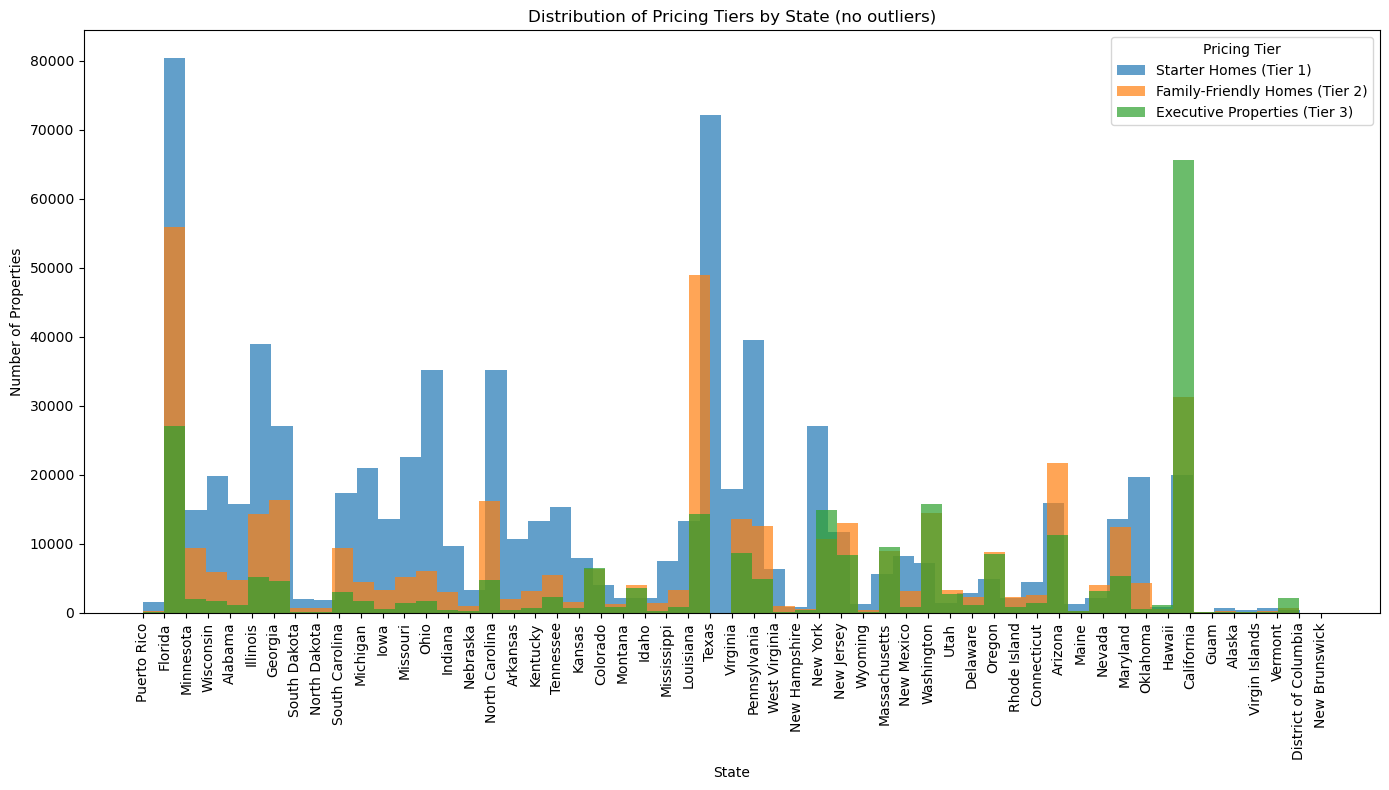

In [25]:
# Create a figure and axis objects with outliers removed
fig, ax = plt.subplots(figsize=(14, 8))

# Iterate over each pricing tier
for tier in df_no_outliers['Pricing Tier'].unique():
    # Filter data for the current pricing tier
    tier_data = df_no_outliers[df_no_outliers['Pricing Tier'] == tier].copy()
    
    # Convert 'state' column to string type
    tier_data['state'] = tier_data['state'].astype(str)
    
    # Plot histogram for the current pricing tier
    ax.hist(tier_data['state'], bins=len(df_no_outliers['state'].unique()), alpha=0.7, label=tier, stacked=True)

# Set labels and title
ax.set_xlabel('State')
ax.set_ylabel('Number of Properties')
ax.set_title('Distribution of Pricing Tiers by State (no outliers)')
ax.legend(title='Pricing Tier')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

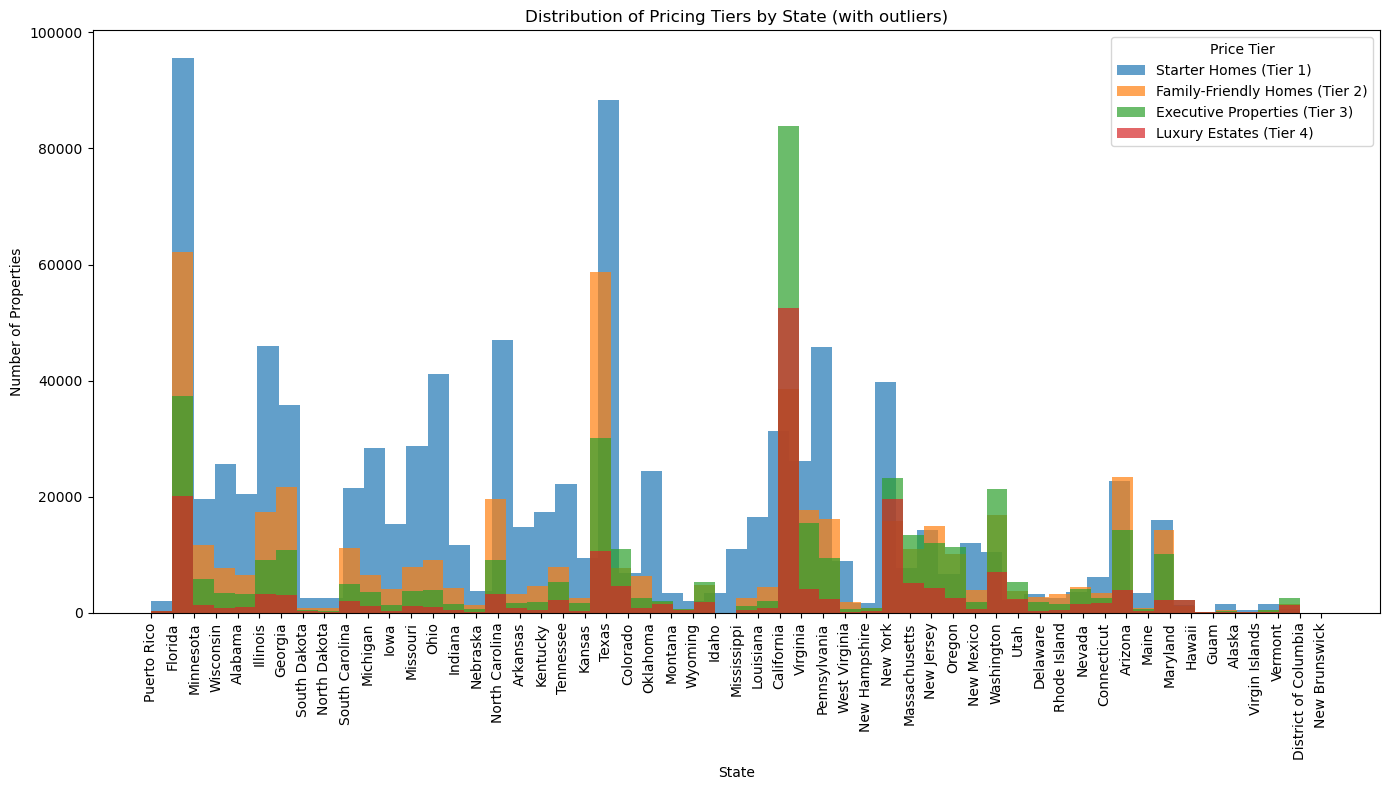

In [26]:
# Create a figure and axis objects with outliers
fig, ax = plt.subplots(figsize=(14, 8))

# Iterate over each pricing tier
for tier in df_cleaned['Pricing Tier'].unique():
    # Filter data for the current pricing tier
    tier_data = df_cleaned[df_cleaned['Pricing Tier'] == tier].copy()
    
    # Convert 'state' column to string type
    tier_data['state'] = tier_data['state'].astype(str)
    
    # Plot histogram for the current pricing tier
    ax.hist(tier_data['state'], bins=len(df_cleaned['state'].unique()), alpha=0.7, label=tier, stacked=True)

# Set labels and title
ax.set_xlabel('State')
ax.set_ylabel('Number of Properties')
ax.set_title('Distribution of Pricing Tiers by State (with outliers)')
ax.legend(title='Price Tier')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

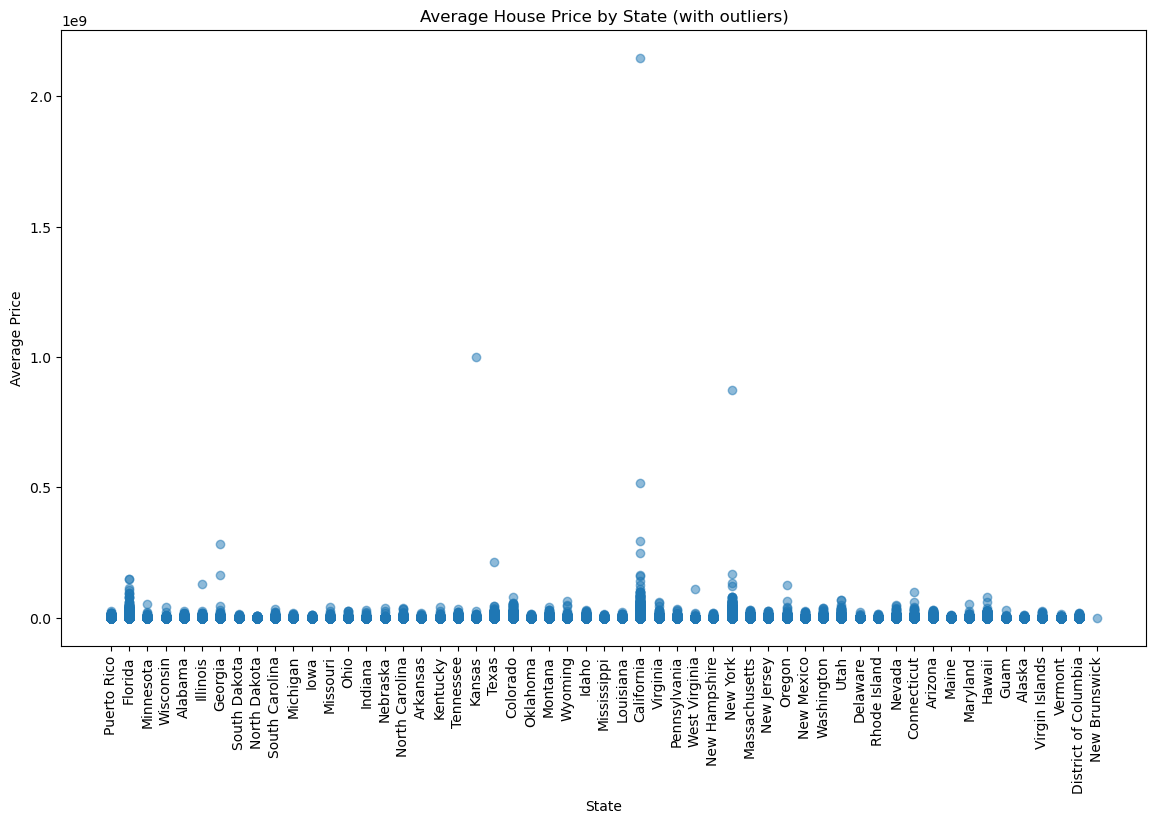

In [33]:
# Group by state and calculate the average price
average = df_cleaned.groupby('state')['price'].mean().reset_index()

# Convert 'state' column to strings with outliers removed
df_cleaned['state'] = df_cleaned['state'].astype(str)

# Explore scatterplot
# Plot scatter plot of state locations
plt.figure(figsize=(14, 8))
plt.scatter(df_cleaned['state'], df_cleaned['price'], alpha=0.5)
plt.title('Average House Price by State (with outliers)')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

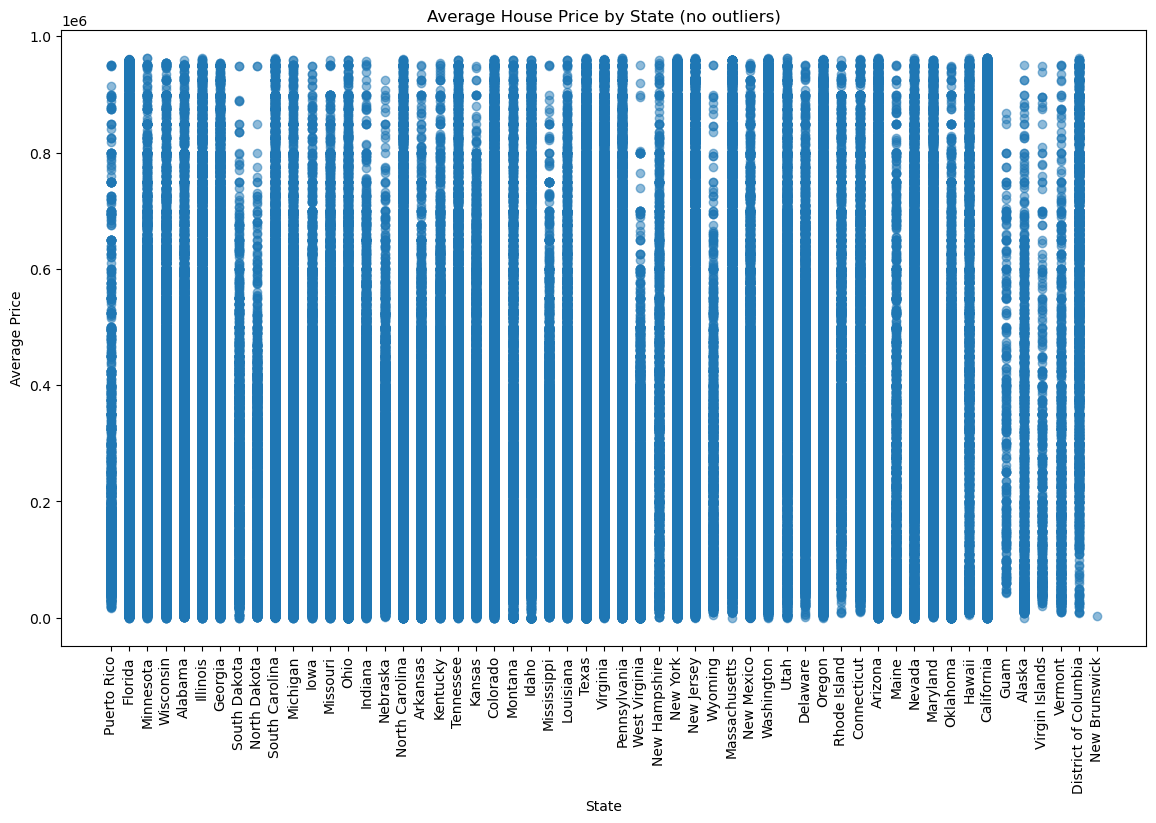

In [32]:
# Group by state and calculate the average price
average = df_no_outliers.groupby('state')['price'].mean().reset_index()

# Convert 'state' column to strings with outliers removed
df_no_outliers['state'] = df_no_outliers['state'].astype(str)

# Explore scatterplot
# Plot scatter plot of state locations
plt.figure(figsize=(14, 8))
plt.scatter(df_no_outliers['state'], df_no_outliers['price'], alpha=0.5)
plt.title('Average House Price by State (no outliers)')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

### Inferential Statistics

In [35]:
# Columns for Chi-Square test
columns_for_chi2 = numerical_columns + categorical_columns

# Create a contingency table for each column
contingency_tables = {}
for col in columns_for_chi2:
    contingency_tables[col] = pd.crosstab(df_cleaned[col], df_cleaned['Pricing Tier'])

# Perform Chi-Square tests
alpha = 0.05
significant_results = {}
for col, table in contingency_tables.items():
    chi2, p_value, _, _ = chi2_contingency(table)
    significant_results[col] = p_value < alpha

# Print results
for col, significant in significant_results.items():
    if significant:
        print(f"Chi-Square test for {col}: Significant association (reject null hypothesis) - Property Tier and {col} are associated.")
    else:
        print(f"Chi-Square test for {col}: No significant association (fail to reject null hypothesis) - Property Tier and {col} are independent.")

Chi-Square test for bed: Significant association (reject null hypothesis) - Property Tier and bed are associated.
Chi-Square test for bath: Significant association (reject null hypothesis) - Property Tier and bath are associated.
Chi-Square test for acre_lot: Significant association (reject null hypothesis) - Property Tier and acre_lot are associated.
Chi-Square test for house_size: Significant association (reject null hypothesis) - Property Tier and house_size are associated.
Chi-Square test for price: Significant association (reject null hypothesis) - Property Tier and price are associated.
Chi-Square test for city: Significant association (reject null hypothesis) - Property Tier and city are associated.
Chi-Square test for state: Significant association (reject null hypothesis) - Property Tier and state are associated.
Chi-Square test for zip_code: Significant association (reject null hypothesis) - Property Tier and zip_code are associated.


### Data Split

In [39]:
# Split the data into training and testing sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (970693, 9) (970693,)
Validation set shape: (208006, 9) (208006,)
Testing set shape: (208006, 9) (208006,)


### Feature Selection

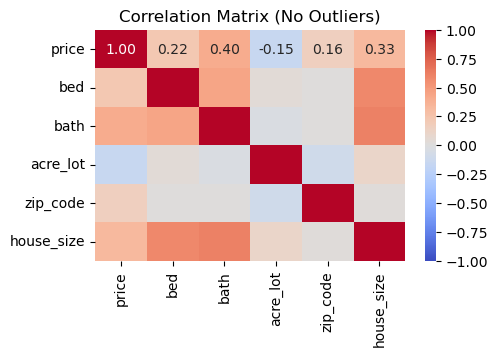


Top 3 features with highest absolute correlation coefficients:
bath: 0.40
bed: 0.22
price: 1.00


In [50]:
# Step 1: Calculate the correlation matrix
numeric_features = df_no_outliers.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = df_no_outliers[numeric_features].corr()

# Step 2: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix (No Outliers)')
plt.show()

# Step 3: Determine the features with the highest absolute correlation coefficients with the target variable
target = 'price'  # Assuming this is the target variable
highest_correlation_features = correlation_matrix.iloc[:-1, -1].abs().nlargest(3).index

# Step 4: Print out the features with the highest absolute correlation coefficients
print("\nTop 3 features with highest absolute correlation coefficients:")
for feature in highest_correlation_features:
    correlation = correlation_matrix.loc[feature, target]
    print(f"{feature}: {correlation:.2f}")


## Model Selection and Analysis